# **Homework 12 - Reinforcement Learning**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2021spring-ta@googlegroups.com



## 前置作業

首先我們需要安裝必要的系統套件及 PyPi 套件。
gym 這個套件由 OpenAI 所提供，是一套用來開發與比較 Reinforcement Learning 演算法的工具包（toolkit）。
而其餘套件則是為了在 Notebook 中繪圖所需要的套件。

In [1]:
!nvidia-smi

Sun Jun  6 15:06:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [3]:
#import os

# your workspace in your drive
#workspace = 'ML2021-hw12'

#try:
#    os.chdir(os.path.join('/content/gdrive/MyDrive/', workspace))
#except:
#    os.mkdir(os.path.join('/content/gdrive/MyDrive/', workspace))
#    os.chdir(os.path.join('/content/gdrive/MyDrive/', workspace))

In [4]:
!apt update
!apt install python-opengl xvfb -y
!pip install -q swig
!pip install box2d==2.3.2 gym[box2d]==0.25.2 box2d-py pyvirtualdisplay tqdm numpy==1.22.4 
!pip install box2d==2.3.2 box2d-kengz
!pip freeze > requirements.txt


0% [Working]
            
Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease

0% [Waiting for headers] [Connecting to security.ubuntu.com (91.189.91.38)] [Co
                                                                               
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease

0% [Waiting for headers] [Connecting to security.ubuntu.com (91.189.91.38)] [Co
0% [1 InRelease gpgv 15.9 kB] [Waiting for headers] [Connecting to security.ubu
                                                                               
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]

0% [1 InRelease gpgv 15.9 kB] [3 InRelease 14.2 kB/88.7 kB 16%] [Connecting to 
                                                                               
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease

0% [1 InRelease gpgv 15.9 kB] [3 InRelease 14.2 kB/88.7 kB 16%] [Connecting to 
                                               

接下來，設置好 virtual display，並引入所有必要的套件。

In [5]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# 請不要更改 random seed !!!!
# 不然在judgeboi上 你的成績不會被reproduce !!!!

In [6]:
seed = 2023 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

最後，引入 OpenAI 的 gym，並建立一個 [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) 環境。

In [7]:
%%capture
import gym
import random

env = gym.make('LunarLander-v2')

fix(env, seed)

## 什麼是 Lunar Lander？

“LunarLander-v2” 這個環境是在模擬登月小艇降落在月球表面時的情形。
這個任務的目標是讓登月小艇「安全地」降落在兩個黃色旗幟間的平地上。
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

所謂的「環境」其實同時包括了 agent 和 environment。
我們利用 `step()` 這個函式讓 agent 行動，而後函式便會回傳 environment 給予的 observation/state（以下這兩個名詞代表同樣的意思）和 reward。

### Observation / State

首先，我們可以看看 environment 回傳給 agent 的 observation 究竟是長什麼樣子的資料：

In [9]:
print(env.observation_space)

Box(-inf, inf, (8,), float32)


`Box(8,)` 說明我們會拿到 8 維的向量作為 observation，其中包含：垂直及水平座標、速度、角度、加速度等等，這部分我們就不細說。
> State has 8 components: horizontal and vertical position, horizontal and vertical velocity, angle and angular velocity, and left and right leg contact
### Action

而在 agent 得到 observation 和 reward 以後，能夠採取的動作有：

In [10]:
print(env.action_space)

Discrete(4)


`Discrete(4)` 說明 agent 可以採取四種離散的行動：
- 0 代表不採取任何行動
- 2 代表主引擎向下噴射
- 1, 3 則是向左右噴射

接下來，我們嘗試讓 agent 與 environment 互動。
在進行任何操作前，建議先呼叫 `reset()` 函式讓整個「環境」重置。
而這個函式同時會回傳「環境」最初始的狀態。

In [11]:
initial_state = env.reset()
print(initial_state)

[ 0.00396109  1.4083536   0.40119505 -0.11407257 -0.00458307 -0.09087662
  0.          0.        ]


接著，我們試著從 agent 的四種行動空間中，隨機採取一個行動

In [12]:
random_action = env.action_space.sample()
print(random_action)

0


再利用 `step()` 函式讓 agent 根據我們隨機抽樣出來的 `random_action` 動作。
而這個函式會回傳四項資訊：
- observation / state
- reward
- 完成與否
- 其餘資訊

In [13]:
observation, reward, done, info = env.step(random_action)

第一項資訊 `observation` 即為 agent 採取行動之後，agent 對於環境的 observation 或者說環境的 state 為何。
而第三項資訊 `done` 則是 `True` 或 `False` 的布林值，當登月小艇成功著陸或是不幸墜毀時，代表這個回合（episode）也就跟著結束了，此時 `step()` 函式便會回傳 `done = True`，而在那之前，`done` 則保持 `False`。

In [15]:
print(done)

False


### Reward

而「環境」給予的 reward 大致是這樣計算：
- 小艇墜毀得到 -100 分
- 小艇在黃旗幟之間成功著地則得 100~140 分
- 噴射主引擎（向下噴火）每次 -0.3 分
- 小艇最終完全靜止則再得 100 分
- 小艇每隻腳碰觸地面 +10 分

> Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points.
> If lander moves away from landing pad it loses reward back.
> Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points.
> Each leg ground contact is +10.
> Firing main engine is -0.3 points each frame.


In [16]:
print(reward) # after doing a random action (0), the immediate reward is stored in this 

-0.8588900517154912


### Random Agent

最後，在進入實做之前，我們就來看看這樣一個 random agent 能否成功登陸月球：

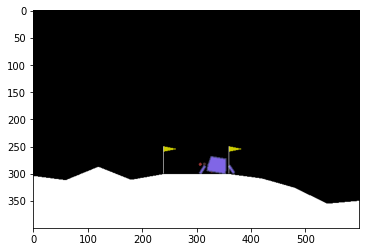

In [17]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

# DQN

現在來搭建一個簡單的 policy network。
我們預設模型的輸入是 8-dim 的 observation，輸出則是離散的四個動作之一：

In [18]:
class DQN(nn.Module):
    def __init__(self, state_size=8, action_size=4, fc1_units=64, fc2_units=64):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

再來，搭建一個簡單的 agent，並搭配上方的 policy network 來採取行動。
這個 agent 能做到以下幾件事：
- `learn()`：從記下來的 log probabilities 及 rewards 來更新 policy network。
- `sample()`：從 environment 得到 observation 之後，利用 policy network 得出應該採取的行動。
而此函式除了回傳抽樣出來的 action，也會回傳此次抽樣的 log probabilities。

In [19]:
from collections import namedtuple

class ReplayMemory:
    """Fixed-size buffer to store experience tuples."""
    def __init__(self, CAPACITY):
        self.capacity = CAPACITY  
        self.memory = []  
        self.index = 0  
        self.transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
        
    def push(self, state, action, state_next, reward):
        """Push a new experience to memory."""
        if len(self.memory) < self.capacity: # if still has capacity, initialize memory[index] to None
            self.memory.append(None)

        self.memory[self.index] = self.transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity  # circular index

    def sample(self, batch_size):
        """Randomly sample a batch of experiences from memory."""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [20]:
class DQNAgent():
    """Interacts with and learns from the environment."""
    def __init__(self, num_states, num_actions):
        """Initialize an Agent object."""
        
        self.num_states = num_states
        self.num_actions = num_actions
        
        # Replay memory
        self.memory_capacity = 10000
        self.memory = ReplayMemory(self.memory_capacity)
        
        # Q-Network
        self.main_q_network = DQN() 
        self.target_q_network = DQN()
        
        # optimizer
        self.optimizer = optim.RMSprop(self.main_q_network.parameters(), lr=1e-4)
    
    def update_q_function(self):
        '''update q function'''
        
        # no enough samples, just return
        if len(self.memory) < BATCH_SIZE:
            return
        # If enough samples are available in memory, get random subset and learn
        self.batch, self.state_batch, self.action_batch, self.reward_batch, self.non_final_next_states = self.make_minibatch()
        
        self.expected_state_action_values = self.get_expected_state_action_values()

        self.update_main_q_network()

    def make_minibatch(self):
        '''Creating a mini-batch'''

        transitions = self.memory.sample(BATCH_SIZE)

        Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
        batch = Transition(*zip(*transitions))


        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])

        return batch, state_batch, action_batch, reward_batch, non_final_next_states

    def get_expected_state_action_values(self):
        '''calculate Q（St,at）'''

        self.main_q_network.eval()
        self.target_q_network.eval()

        self.state_action_values = self.main_q_network(
            self.state_batch).gather(1, self.action_batch)

        non_final_mask = torch.BoolTensor(tuple(map(lambda s: s is not None,
                                                    self.batch.next_state)))
        # set all state to 0
        next_state_values = torch.zeros(BATCH_SIZE)

        next_state_values[non_final_mask] = self.target_q_network(
            self.non_final_next_states).max(1)[0].detach()
        # DQN formula
        expected_state_action_values = self.reward_batch + GAMMA * next_state_values
        
        return expected_state_action_values 
        
    def get_action(self, state, episode, test=False):
        """Returns actions for given state as per current policy."""
        if test:
            self.main_q_network.eval()
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action = self.main_q_network(torch.from_numpy(state).unsqueeze(0)).max(1)[1].view(1, 1)
            return action.item()
        
        global steps_done
        # Epsilon-greedy policy
        #epsilon = episode
        #epsilon = 0.5 * (1 / (episode + 1))
        epsilon = EPS_END + (EPS_START - EPS_END) * \
                np.exp(-1. * steps_done / EPS_DECAY)
        #print('epsilon', epsilon)
        
        steps_done += 1
        
        if epsilon <= np.random.uniform(0, 1):
            #print('use max')
            self.main_q_network.eval()
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action = self.main_q_network(state).max(1)[1].view(1, 1)
        else:
            #print('random')
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])  
            
        return action

    def update_main_q_network(self):
        
        '''update main q net'''

        # set train mode
        self.main_q_network.train()
        # Hurberloss function
        # expected_state_action_values (minbatch,)->(minbatchx1)

        loss = F.smooth_l1_loss(self.state_action_values,
                                self.expected_state_action_values.unsqueeze(1))

        # update
        self.optimizer.zero_grad()  # reset gradient
        loss.backward()  # backpropagation
        for param in self.main_q_network.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()  # update network


    def memorize(self, state, action, state_next, reward):
        '''save state, action, state_next, reward into replay memory'''
        self.memory.push(state, action, state_next, reward)

    def update_target_q_function(self):
        
        '''synchronize Target Q-Network to Main Q-Network'''
        self.target_q_network.load_state_dict(self.main_q_network.state_dict())  

最後，建立一個 network 和 agent，就可以開始進行訓練了。

In [21]:
network = DQN()
agent = DQNAgent(env.observation_space.shape[0], env.action_space.n)

## 訓練 Agent

現在我們開始訓練 agent。
透過讓 agent 和 environment 互動，我們記住每一組對應的 log probabilities 及 reward，並在成功登陸或者不幸墜毀後，回放這些「記憶」來訓練 policy network。

In [ ]:
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 600        # 總共更新 400 次
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

best_score = 0
best_batch = 0

# 訓練前，先確保 network 處在 training 模式
agent.main_q_network.train()
agent.target_q_network.train()
steps_done = 0

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    rewards = []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        
        observation = env.reset() # 環境的初始化
        state = observation  # 將觀測結果直接當成狀態s使用
        state = torch.from_numpy(state).type(
                torch.FloatTensor)  # 將NumPy變數轉換成PyTorch的張量
        state = torch.unsqueeze(state, 0)  # 將size 4轉換成size 1x4
        total_reward, total_step = 0, 0

        while True:

            action = agent.get_action(state, batch)  # 求出動作
            # 執行動作a_t後，算出s_{t+1}與done旗標
            # 根據action指定.item()、再取得內容
            observation_next, reward, done, _ = env.step(action.item())  # 不會用到info，所以設定為_

            total_reward += reward
            total_step += 1
            rewards.append(reward) #改這裡
            # ! 重要 ！
            # 現在的reward 的implementation 為每個時刻的瞬時reward, 給定action_list : a1, a2, a3 ......
            #                                                       reward :     r1, r2 ,r3 ......
            # medium：將reward調整成accumulative decaying reward, 給定action_list : a1,                         a2,                           a3 ......
            #                                                       reward :     r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,r3+0.99*r4+0.99^2*r5+ ......
            # boss : implement DQN
            if done:
                state_next = None  # 沒有下個狀態，所以存入None

            else:
                state_next = observation_next  # 直接將觀測結果當成狀態使用
                state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)  # 將numpy變數轉換成PyTorch的張量
                state_next = torch.unsqueeze(state_next, 0)  # 將size 4轉換成size 1x4
                
            # 將學習經驗存入記憶體
            agent.memorize(state, action, state_next, torch.FloatTensor([reward]))
            
            # 以Experience Replay更新Q函數
            agent.update_q_function()
            
            # 觀測狀態的更新
            state = state_next
            
            # 結束時的處理
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break
                

    #print(f"rewards looks like ", np.shape(rewards))      
    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    # rewards = np.concatenate(rewards, axis=0)
    #rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    agent.update_target_q_function()
    print("torch.from_numpy(rewards) looks like ", torch.from_numpy(np.array(rewards)).size())


    ### testing

    fix(env, seed)
    agent.main_q_network.eval()  # 測試前先將 network 切換為 evaluation 模式
    NUM_OF_TEST = 5 # Do not revise it !!!!!
    test_total_reward = []
    action_list = []
    for i in range(NUM_OF_TEST):
        actions = []
        state = env.reset()

        #img = plt.imshow(env.render(mode='rgb_array'))

        total_reward = 0

        done = False
        while not done:
            action = agent.get_action(state, episode=i, test=True)
            actions.append(action)
            state, reward, done, _ = env.step(action)

            total_reward += reward

            #img.set_data(env.render(mode='rgb_array'))
            #display.display(plt.gcf())
            #display.clear_output(wait=True)
        print(total_reward)
        test_total_reward.append(total_reward)

        action_list.append(actions) #儲存你測試的結果
        print("length of actions is ", len(actions))
    print(f"Your final reward is : %.2f"%np.mean(test_total_reward))
    if np.mean(test_total_reward) > 250:
        distribution = {}
        for actions in action_list:
            for action in actions:
                if action not in distribution.keys():
                    distribution[action] = 1
                else:
                    distribution[action] += 1
        PATH = "Action_List_test" + str(batch) + ".npy" # 可以改成你想取的名字或路徑
        np.save(PATH ,np.array(action_list)) 
        if np.mean(test_total_reward) > best_score:
            best_score = np.mean(test_total_reward)
            best_batch = batch
            print('Improve to score %.2f at batch %d'% (best_score, best_batch ))

### 訓練結果

訓練過程中，我們持續記下了 `avg_total_reward`，這個數值代表的是：每次更新 policy network 前，我們讓 agent 玩數個回合（episodes），而這些回合的平均 total rewards 為何。
理論上，若是 agent 一直在進步，則所得到的 `avg_total_reward` 也會持續上升，直至 250 上下。
若將其畫出來則結果如下：

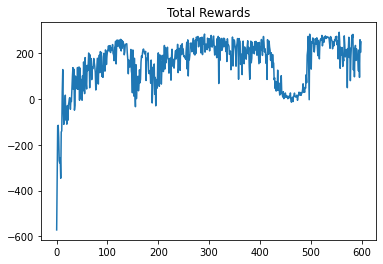

In [23]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

另外，`avg_final_reward` 代表的是多個回合的平均 final rewards，而 final reward 即是 agent 在單一回合中拿到的最後一個 reward。
如果同學們還記得環境給予登月小艇 reward 的方式，便會知道，不論**回合的最後**小艇是不幸墜毀、飛出畫面、或是靜止在地面上，都會受到額外地獎勵或處罰。
也因此，final reward 可被用來觀察 agent 的「著地」是否順利等資訊。

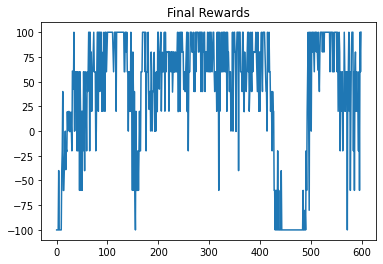

In [24]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

訓練時間


# Server 測試
到時候下面會是我們Server上測試的環境，可以給大家看一下自己的表現如何

/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


Your reward is : 265.14
Your reward is : 304.10
Your reward is : 254.52
Your reward is : 307.27
Your reward is : 303.36


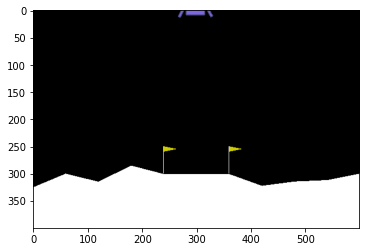

In [29]:
PATH = "Action_List_test" + str(best_batch) + ".npy"
action_list = np.load(PATH,allow_pickle=True) #到時候你上傳的檔案
seed = 2023 #到時候測試的seed 請不要更改
fix(env, seed)

#agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式

test_total_reward = []
for actions in action_list:
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))

    total_reward = 0

    done = False
    # while not done:
    done_count = 0
    for action in actions:
        # action, _ = agent1.sample(state)
        state, reward, done, _ = env.step(action)
        done_count += 1
        total_reward += reward
        if done:
            break
    #   img.set_data(env.render(mode='rgb_array'))
    #   display.display(plt.gcf())
    #   display.clear_output(wait=True)
    print(f"Your reward is : %.2f"%total_reward)
    test_total_reward.append(total_reward)

# 你的成績

In [27]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 286.88


# Reference
* https://github.com/ranjitation/DQN-for-LunarLander
* https://github.com/udacity/deep-reinforcement-learning
* https://github.com/openai/baselines
* https://github.com/YutaroOgawa/Deep-Reinforcement-Learning-Book
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://titanwolf.org/Network/Articles/Article?AID=15c7d9d5-1a0a-41e8-96fb-23a900e10d3b#gsc.tab=0

## 參考資料

以下是一些有用的參考資料。
建議同學們實做前，可以先參考第一則連結的上課影片。
在影片的最後有提到兩個有用的 Tips，這對於本次作業的實做非常有幫助。

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
